In [1]:
## Parkinsons Telemonitoring Data Set 
# https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring
%load_ext autoreload
%autoreload 2

In [45]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2, l1
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy
from scipy.cluster.vq import whiten
from sklearn.preprocessing import MinMaxScaler

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain, ProbDense

#Import DeepLift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

from math import pi
from scipy.special import erf, erfc
from scipy.stats import norm
exp = np.exp
def rect_mean(mus, vs):
    assert mus.shape == vs.shape
    m = mus
    v = vs
    s = v**0.5
    return mus*norm.cdf(mus/s) + s*norm.pdf(mus/s)

def rect_var(mus, vs, mus_relu):
    assert mus.shape == vs.shape
    m = mus
    v = vs
    s = v**0.5
    r1 = (mus**2 + v)*norm.cdf(mus/s)
    r2 = (mus*s)*norm.pdf(mus/s)
    return r1+r2-mus_relu**2





In [3]:
# Build and train a network.

np.random.seed(15) # for riproducibility

SKIP_TRAIN = True
saved_model_file = 'model_park.h5'
saved_model_weights_file = 'model_park_w.h5'

batch_size = 64
epochs = 1000

# Load data from CSV
data = np.loadtxt(open("data/parkinsons_updrs.csv", "rb"), delimiter=",", skiprows=1).astype(np.float32)


np.random.shuffle(data)
data_y = data[:, 5]
data_x = data[:, [1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

scaler = MinMaxScaler(feature_range=(-1, 1))
print(scaler.fit(data_x))
data_x = scaler.transform(data_x)

assert np.isnan(data_x).any() == False
assert np.isnan(data_y).any() == False


print (data_x.shape)
x_test = data_x[:880]
y_test = data_y[:880]
x_train = data_x[880:]
y_train = data_y[880:]


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print (y_train)
activation = 'relu'

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    model = Sequential()
    model.add(Dense(128, input_shape=(x_train.shape[1],), activation=activation, kernel_regularizer=l1(0.0)), name='dens_1')
    model.add(Dropout(0.2))
    model.add(Dense(64, activation=activation, kernel_regularizer=l1(0.0)), name='dens_2')
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_regularizer=l1(0.0)), name='dens_3')
    
    stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.adam(),
                  metrics=['mae'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              callbacks=[stop],
              validation_data=(x_test, y_test))
    #model.save(saved_model_file)
    #model.save_weights(saved_model_weights_file)
print ("Done")
model.evaluate(x_test, y_test)



MinMaxScaler(copy=True, feature_range=(-1, 1))
(5875, 18)
x_train shape: (4995, 18)
4995 train samples
880 test samples
[17.699  36.747   7.8128 ... 15.419  18.199  40.196 ]
Done
880/880 [==============================] - 0s 139us/step


[23.389765271273525, 3.6275627569718796]

In [4]:
idxs = np.random.choice(range(5875), 20, replace=False)
model.evaluate(data_x[idxs], data_y[idxs])

20/20 [==============================] - 0s 43us/step


[34.71617889404297, 4.4336042404174805]

In [5]:
#model.save(saved_model_file)
#model.save_weights(saved_model_weights_file)

In [6]:
xs = x_test[0:200]
ys = y_test[0:200]

In [7]:
%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor, input_tensor, xs)
    a_res = de.explain('deeplift', target_tensor, input_tensor, xs)
    a_rc = de.explain('deeplift_rc', target_tensor, input_tensor, xs)
    #a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    #a_layershap = de.explain('shapley', target_tensor, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    a_occl = de.explain('occlusion', target_tensor, input_tensor, xs)
    print ("Done")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
{<tf.Tensor 'dense_1_input:0' shape=(?, 18) dtype=float32>: array([[-0.46938777, -1.        , -0.92739004, ...,  0.11397934,
         0.14233685, -0.43239772],
       [ 0.5510204 , -1.        , -0.9582492 , ...,  0.2144872 ,
        -0.30242372, -0.63311714],
       [-0.22448993, -1.        , -0.61133516, ...,  0.19520044,
         0.26208878,  0.00372946],
       ...,
       [-0.10204077,  1.        , -0.94312215, ..., -0.5962997 ,
        -0.19302535, -0.6693554 ],
       [-0.06122446, -1.        , -0.85155296, ...,  0.09518313,
         0.34878826, -0.4828664 ],
       [ 0.5102041 ,  1.        , -0.936668  , ...,  0.11577058,
        -0.10240078, -0.42769182]], dtype=float32), <tf.Tensor 'dropout_1/keras_learning_phase/input:0' shape=() dtype=bool>: 0}
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inpu

In [8]:
# Params
xn = 50

# Flatten all inputs
x = np.copy(xs.reshape(xs.shape[0], -1))
print (x.shape)
# Prepare array for output
result = np.zeros_like(x)
# Count how many input features are there
n_input_feat = x.shape[1]
# Define sub-coalition sizes
Ks = range (0, n_input_feat, max(1, n_input_feat//xn))
print (Ks)

for i, xi in enumerate(x):
    print ('Sample %d...' % i)
    for j in range(n_input_feat):
        for ki in range(len(Ks)):
            k = Ks[ki] # coalition size
            first = True
            mu1, mu2, v1, v2 = None, None, None, None
            for li, l in enumerate(model.layers):
                weights = l.get_weights()
                if (len(weights)):
                    kernel = weights[0]
                    n_output_feat = kernel.shape[1]
                    bias = weights[1]
                    if first is True:
                        first = False
                        sample = xi
                        sample_i = sample.copy()
                        sample_i[j] = 0
                        # Dense is essentially a dot product.
                        # Here, instead of 1, we do 3 dot products
                        dot = np.dot(sample, kernel)
                        dot_i = np.dot(sample_i, kernel)
                        dot_v = np.dot(sample_i ** 2, kernel ** 2)
                        # Compute mean without feature i
                        mu = dot_i / (n_input_feat - 1)
                        # Compensate for number of players in current coalition
                        mu1 = mu * k
                        # Compute mean of the distribution that also includes player i (acting as bias to expectation)
                        mu2 = mu1 + (dot - dot_i)
                        # Compute variance without player i
                        v1 = dot_v / (n_input_feat - 1) - mu**2
                        # Compensate for number or players in the coalition
                        v1 = v1 * k
                        # Set something different than 0 if necessary
                        v1 = np.maximum(0.00001, v1)
                        # Since player i is only a bias, at this point the variance of the distribution than
                        # includes it is the same
                        v2 = v1
#                         v1 = np.diag(v1)
#                         v2 = np.diag(v2)
                        
                    else:
                        assert first is not True
                        mu1 = np.dot(mu1, kernel)
                        mu2 = np.dot(mu2, kernel)
#                         assert np.min(np.diag(v1)) >= 0, np.min(np.diag(v1))
#                         v1 = kernel.T @ v1.T @ kernel
#                         v2 = kernel.T @ v2.T @ kernel
#                         np.fill_diagonal(v1, np.maximum(0.0000001,np.diag(v1)))
#                         np.fill_diagonal(v2, np.maximum(0.0000001,np.diag(v2)))
#                         assert np.min(np.diag(v1)) >= 0, np.min(np.diag(v1))
                        v1 = np.dot(v1, kernel ** 2)
                        v2 = np.dot(v2, kernel ** 2)
        
                        v1 = np.maximum(0.00001, v1)
                        v2 = np.maximum(0.00001, v2)

                    assert mu1.shape == (n_output_feat,), mu1.shape
                    assert mu2.shape == (n_output_feat,), mu2.shape
                    #assert v1.shape == (n_output_feat,), v1.shape
                    #assert v2.shape == (n_output_feat,), v2.shape

                    # Translate if there is a bias
                    if bias is not None:
                        mu1 += bias
                        mu2 += bias

                    # Apply relu if there
                    if l.activation.__name__ is 'relu':
                        t = rect_mean(mu1, v1)
                        v1 = rect_var(mu1, v1)
                        mu1 = t
                        t = rect_mean(mu2, v2)
                        v2 = rect_var(mu2, v2)
                        mu2 = t
                        
#                         t = rect_mean(mu1, np.diag(v1))
#                         _v1 = rect_var(mu1, np.diag(v1))
#                         #assert np.min(_v1) >= 0, np.min(_v1)
#                         _v1 = np.maximum(0.000001, _v1)
#                         np.fill_diagonal(v1, _v1)
#                         mu1 = t
#                         t = rect_mean(mu2, np.diag(v2))
#                         _v2 = rect_var(mu2, np.diag(v2))
#                         _v2 = np.maximum(0.000001, _v2)
#                         np.fill_diagonal(v2, _v2)
#                         mu2 = t
                    elif l.activation.__name__ is not 'linear':
                        raise Exception("Activation can only be ReLU or linear")
            
            # Once we went through all the layers
            # mu1, mu2, v1, v2 are the parameters of the distributions at the output
            result[i, j] += (mu2 - mu1)
            
            
        # Once we went though all coalition sizes we are basically done for feature j of sample i
        result[i, j] /= len(Ks)
a_shap2 = result
print ('Done')
print (a_shap2.shape)


(200, 18)
range(0, 18)
Sample 0...
Sample 1...
Sample 2...
Sample 3...
Sample 4...
Sample 5...
Sample 6...
Sample 7...
Sample 8...
Sample 9...
Sample 10...
Sample 11...
Sample 12...
Sample 13...
Sample 14...
Sample 15...
Sample 16...
Sample 17...
Sample 18...
Sample 19...
Sample 20...
Sample 21...
Sample 22...
Sample 23...
Sample 24...
Sample 25...
Sample 26...
Sample 27...
Sample 28...
Sample 29...
Sample 30...
Sample 31...
Sample 32...
Sample 33...
Sample 34...
Sample 35...
Sample 36...
Sample 37...
Sample 38...
Sample 39...
Sample 40...
Sample 41...
Sample 42...
Sample 43...
Sample 44...
Sample 45...
Sample 46...
Sample 47...
Sample 48...
Sample 49...
Sample 50...
Sample 51...
Sample 52...
Sample 53...
Sample 54...
Sample 55...
Sample 56...
Sample 57...
Sample 58...
Sample 59...
Sample 60...
Sample 61...
Sample 62...
Sample 63...
Sample 64...
Sample 65...
Sample 66...
Sample 67...
Sample 68...
Sample 69...
Sample 70...
Sample 71...
Sample 72...
Sample 73...
Sample 74...
Sample 75...

In [9]:
# Compute exacly shapley values!
saved_file = 'exact.npy'
a_exact = np.zeros_like(a_gradin)
if True or not SKIP_TRAIN:
    from deepexplain.tensorflow.exact_shapley import compute_shapley
    a_exact = np.array([compute_shapley(xx, lambda x: model.predict(np.array(x)).sum(-1)) for xx, yy in zip(xs, ys)])
    np.save(saved_file, a_exact)
else:
    a_exact = np.load(saved_file)


In [29]:
np.save('exact_parkinson200.npy', a_exact)

Text(0.5, 1.0, 'Exact Shap')

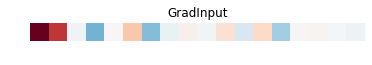

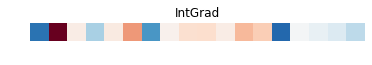

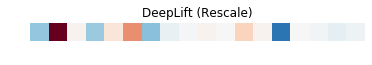

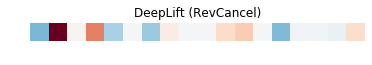

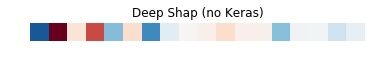

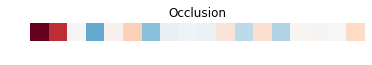

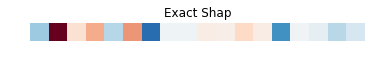

In [10]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
idx = 0
shape = (1, 18)
plot(a_gradin[idx].reshape(shape)).title('GradInput')
plt.figure()
plot(a_intgrad[idx].reshape(shape)).title('IntGrad')
plt.figure()
plot(a_res[idx].reshape(shape)).title('DeepLift (Rescale)')
#plt.figure()
#plot((a_linear)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Linear')
plt.figure()
plot(a_rc[idx].reshape(shape)).title('DeepLift (RevCancel)')
plt.figure()
# plot((a_shap)[idx].reshape(shape)).title('Deep Shap')
# plt.figure()
plot((a_shap2)[idx].reshape(shape)).title('Deep Shap (no Keras)')
plt.figure()
plot((a_occl)[idx].reshape(shape)).title('Occlusion')
plt.figure()
# plot((a_layershap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Layerwise Shap')
# plt.figure()
#plot((a_shaplud)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('SHAP')
#plt.figure()
plot((a_exact)[idx].reshape(shape)).title('Exact Shap')



        
        


In [11]:
print (np.mean(np.abs(a_shap2-a_exact)))
print (np.mean(np.abs(a_intgrad-a_exact)))

1.110080885676954
4.280151861378956


y0:  [[32.428646]]
Summation to Delta test
==> Gradin: 10.624656
==> Intgrad: 3.523540910374396
==> DL Rescale: 3.5461068
==> DL RevCan: 6.706723
==> DL Shap 2: 8.006152
==> DL Exact Shapley: 3.5461070216501027
MSE with Occlusion  31.261408114035955
MSE with DeepShap  2.670510777869172
MSE with DeepLift  33.581722705352746
MSE with DeepLift (Rescale)  33.42928348157692
MSE with Int Gradients  42.76355884377704
MSE with GradInput  73.39557554373293
Kendall corr.  with Occlusion  0.2808496732026144
Kendall corr.  with DeepShap  0.7736601307189546
Kendall corr.  with DeepLift  0.6410457516339869
Kendall corr.  with DeepLift (rescale) 0.49790849673202614
Kendall corr.  with Int Gradients  0.449607843137255
Kendall corr.  with GradInput  0.20379084967320263


<Figure size 432x288 with 0 Axes>

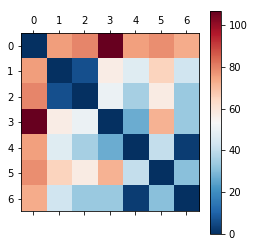

<Figure size 432x288 with 0 Axes>

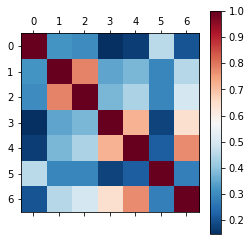

In [12]:
methods = [a_gradin, a_intgrad, a_res, a_rc, a_shap2, a_occl, a_exact]
confusion = np.zeros((len(methods), len(methods)))
confusion[:] = np.nan
confusion_r = np.zeros((len(methods), len(methods)))
confusion_r[:] = np.nan

# Summation to delta test
y0 = model.predict(np.zeros_like(xs[0:1]))
print ("y0: ", y0)
print ("Summation to Delta test")
print ("==> Gradin:" , np.mean(np.abs(a_gradin.sum(1) + y0 - ys)))
print ("==> Intgrad:" , np.mean(np.abs(a_intgrad.sum(1) + y0 - ys)))
print ("==> DL Rescale:" , np.mean(np.abs(a_res.sum(1) + y0 - ys)))
print ("==> DL RevCan:" , np.mean(np.abs(a_rc.sum(1) + y0 - ys)))
print ("==> DL Shap 2:" , np.mean(np.abs(a_shap2.sum(1) + y0 - ys)))
print ("==> DL Exact Shapley:" , np.mean(np.abs(a_exact.sum(1) + y0 - ys)))



n = a_gradin.shape[0]
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i >= j:
            m1 = m1.reshape(n, -1)
            m2 = m2.reshape(n, -1)
            confusion[i][j] = ((m1-m2)**2).mean()
            confusion_r[i][j] = np.mean([scipy.stats.kendalltau(x, y)[0] for x,y in zip(m1, m2)])
            confusion[j][i] = confusion[i, j]
            confusion_r[j][i] = confusion_r[i, j]
plt.figure()
plt.matshow(confusion, cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.matshow(confusion_r, cmap='RdBu_r')
plt.colorbar()
#print ('MSE with SHAP ', confusion[-1][-2])
comparison = -1
print ('MSE with Occlusion ', confusion[-2][comparison])
print ('MSE with DeepShap ', confusion[-3][comparison])
print ('MSE with DeepLift ', confusion[-4][comparison])
print ('MSE with DeepLift (Rescale) ', confusion[-5][comparison])
print ('MSE with Int Gradients ', confusion[-6][comparison])
print ('MSE with GradInput ', confusion[-7][comparison])

#print ('Kendall corr. with SHAP ', confusion_r[-1][-2])
print ('Kendall corr.  with Occlusion ', confusion_r[-2][comparison])
print ('Kendall corr.  with DeepShap ', confusion_r[-3][comparison])
print ('Kendall corr.  with DeepLift ', confusion_r[-4][comparison])
print ('Kendall corr.  with DeepLift (rescale)', confusion_r[-5][comparison])
print ('Kendall corr.  with Int Gradients ', confusion_r[-6][comparison])
print ('Kendall corr.  with GradInput ', confusion_r[-7][comparison])

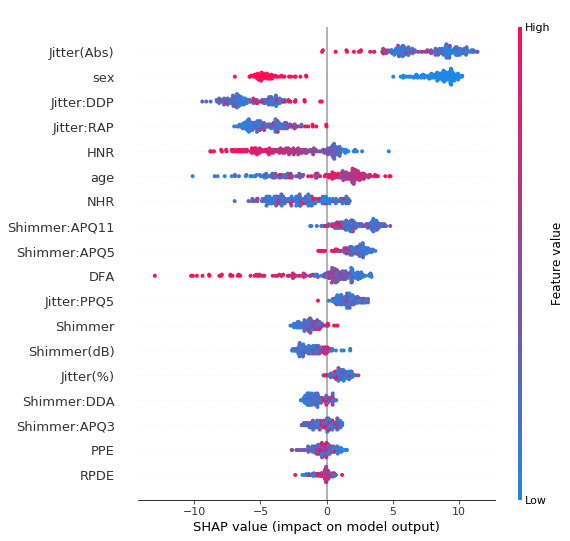

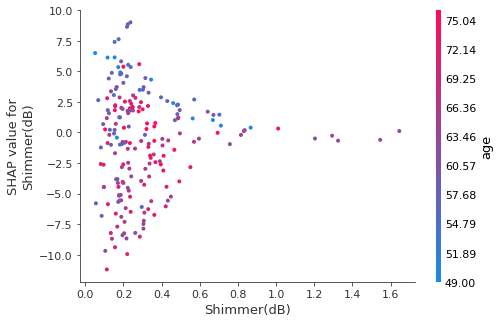

In [28]:
import shap
feat_names = [
"age","sex","Jitter(%)","Jitter(Abs)","Jitter:RAP","Jitter:PPQ5","Jitter:DDP","Shimmer","Shimmer(dB)","Shimmer:APQ3"
    ,"Shimmer:APQ5","Shimmer:APQ11","Shimmer:DDA","NHR","HNR","RPDE","DFA","PPE"]

#shap.summary_plot(a_rc, xs, feat_names)
shap.summary_plot(a_shap2, xs, feat_names)

shap.dependence_plot(8, a_intgrad, scaler.inverse_transform(xs), feature_names=feat_names,  interaction_index='auto')
shap.initjs()
shap.force_plot(ys[0], a_shap2[0,:], feature_names=feat_names)

In [14]:
shap.force_plot(ys[0], a_intgrad[0,:], feature_names=feat_names)

In [15]:
shap.force_plot(ys[0], a_exact[0,:], feature_names=feat_names)